In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, Adamax, Ftrl, Nadam

#### Load Symptom Dataset

In [2]:
data = pd.read_csv('./Data/dataset.csv', sep = ',')

####  Load Symptom Severity 

In [3]:
severity = pd.read_csv('./Data/Symptom-severity.csv')

####  Load Exam Mapping

In [4]:
mapping = pd.read_csv('./Data/map.csv', sep = ';')

# Pre-processing

### One-hot encoding of Symptoms + Mapping the severity of the symptoms

In [5]:
symptomsCols = pd.unique(data.drop('Disease',1).values.flatten())
onlySymptomsCols=[]
for elem in (symptomsCols[symptomsCols==symptomsCols]):
    onlySymptomsCols.append(elem.replace(' ',''))

weightsFromSymptom = dict()

indexing = severity.to_dict()['Symptom']
weights = severity.to_dict()['Weight']
for elem in indexing:
    weightsFromSymptom[indexing[elem].replace(' ','')]=weights[elem]

for elem in onlySymptomsCols:
    if(elem.replace(' ', '') not in indexing.values()):
        weightsFromSymptom[elem.replace(' ','')]=1

symptomsCols = np.insert(onlySymptomsCols, 0, 'Disease')
symptomsCols

dataf = []
for elem in data.values:
    line=[]
    line.append(elem[0])
    elemlist=[]
    oldline = elem.tolist()
    for e in (oldline):
        if(e==e):
            elemlist.append(e.replace(' ', ''))
    del elemlist[0]
    for symptom in onlySymptomsCols:
        if(elemlist.count(symptom)>0):
            weight = weightsFromSymptom[symptom.replace(' ','')]
            line.append(weight)
        else:
            line.append(0)
    dataf.append(line)

processedDataf = pd.DataFrame(data=dataf, columns=symptomsCols)
processedDataf.to_csv("./Data/processed.csv", index=False )
processedDataf

,Disease,itching,skinrash,nodalskineruptions,dischromicpatches,continuoussneezing,shivering,chills,wateringfromeyes,stomachpain,...,bladderdiscomfort,foulsmellofurine,continuousfeelofurine,skinpeeling,silverlikedusting,smalldentsinnails,inflammatorynails,blister,redsorearoundnose,yellowcrustooze
0,Fungal infection,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,(vertigo) Paroymsal Positional Vertigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4916,Acne,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4917,Urinary tract infection,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
4918,Psoriasis,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,0


### One-hot encoding of exams and diseases

In [6]:
mapeamentoCols = pd.unique(mapping.drop('Disease',1).values.flatten())

onlyTestCols=[]
onlyTestCols = mapeamentoCols[mapeamentoCols==mapeamentoCols]
dfCols = np.insert(onlyTestCols, 0, 'Disease')

dfValues = []
for elem in mapping.values:
    line=[]
    line.append(elem[0])
    elemlist= elem.tolist()
    del elemlist[0]
    for test in onlyTestCols:
        if(elemlist.count(test)>0):
            line.append(1)
        else:
            line.append(0)
    dfValues.append(line)

testsDf = pd.DataFrame(data=dfValues, columns=dfCols)
testsDf.to_csv("./Data/mapProcessed.csv", index=False)

testsDf

,Disease,Blood Tests,Skin biopsy,Patch test,Complete blood count (CBC),Polymerase chain reaction (PCR),Skin Prick Test (SPT),Intradermal Skin Test,Physical Examination,TSH test,...,Pleural fluid culture,Pulse oximetry,Anti-cyclic citrullinated peptide (anti-CCP),Erythrocyte sedimentation rate (ESR),C-reactive protein (CRP),Antinuclear antibody (ANA),HLA-B27,Stool culture,Antigen Tests,Mantoux tuberculin skin test
0,Drug Reaction,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Malaria,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Allergy,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Hypothyroidism,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Psoriasis,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,GERD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Chronic cholestasis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,hepatitis A,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,Osteoarthristis,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,(vertigo) Paroymsal Positional Vertigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Dataframe with all Symptoms + Exams associated with a Disease

In [7]:
finalDfCols= np.concatenate([onlyTestCols,onlySymptomsCols])

dfValues = []
for elem in processedDataf.values:
    for testLine in testsDf.values:
        if(testLine[0]==elem[0]):
            line= np.concatenate([testLine[1:], elem[1:]])
            dfValues.append(line)

finalDf = pd.DataFrame(data=dfValues, columns=finalDfCols)
finalDf.to_csv("./Data/final.csv", index=False)
finalDf

,Blood Tests,Skin biopsy,Patch test,Complete blood count (CBC),Polymerase chain reaction (PCR),Skin Prick Test (SPT),Intradermal Skin Test,Physical Examination,TSH test,T4 test,...,bladderdiscomfort,foulsmellofurine,continuousfeelofurine,skinpeeling,silverlikedusting,smalldentsinnails,inflammatorynails,blister,redsorearoundnose,yellowcrustooze
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4676,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4677,1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
4678,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,1,1,1,0,0,0


In [8]:
print(onlyTestCols)
print(len(onlyTestCols))
print(len(onlySymptomsCols))

['Blood Tests' 'Skin biopsy' 'Patch test' 'Complete blood count (CBC)'
 'Polymerase chain reaction (PCR)' 'Skin Prick Test (SPT)'
 'Intradermal Skin Test' 'Physical Examination' 'TSH test' 'T4 test'
 'Thyroid scan' 'Thyroid ultrasound' 'Esophagram' 'Esophageal manometry'
 'pH monitoring' 'Endoscopy' 'Biopsy of upper disgestive system'
 'X-ray of upper digestive system' 'Serum bilirubin test'
 'Serum albumin test' 'Serum alkaline phosphatase test'
 'Serum aminotransferases (transaminases)' 'Prothrombin time (PTT) test'
 'Alanine transaminase (ALT) test' 'Liver Ultrasound' 'Liver Biopsy'
 'MRI Scan' 'CT Scan' 'X-ray' 'Electronystagmography (ENG)'
 'Videonystagmography (VNG)' 'Fasting plasma glucose (FPG) test'
 'Hemoglobin A1C test' 'Random plasma glucose (RPG) test' 'Blood Test'
 'Electrocardiogram (ECG)' 'Echocardiogram' 'Ambulatory monitoring'
 'Urine analysis' 'Upper gastrointestinal endoscopy'
 'Upper gastrointestinal biopsy' 'CT scan' 'Helicobacter pylori tests'
 'Anoscopy' 'Rigid 

In [9]:
print('Number of Symptoms:', len(severity['Symptom']))

for elem in (severity['Symptom'].tolist()) :
        if(elem  not in onlySymptomsCols  ):
            print(elem)

Number of Symptoms: 131
skin_rash
nodal_skin_eruptions
continuous_sneezing
joint_pain
stomach_pain
ulcers_on_tongue
muscle_wasting
burning_micturition
spotting_urination
weight_gain
cold_hands_and_feets
mood_swings
weight_loss
patches_in_throat
irregular_sugar_level
high_fever
sunken_eyes
yellowish_skin
dark_urine
loss_of_appetite
pain_behind_the_eyes
back_pain
abdominal_pain
mild_fever
yellow_urine
yellowing_of_eyes
acute_liver_failure
fluid_overload
swelling_of_stomach
swelled_lymph_nodes
blurred_and_distorted_vision
throat_irritation
redness_of_eyes
sinus_pressure
runny_nose
chest_pain
weakness_in_limbs
fast_heart_rate
pain_during_bowel_movements
pain_in_anal_region
bloody_stool
irritation_in_anus
neck_pain
swollen_legs
swollen_blood_vessels
puffy_face_and_eyes
enlarged_thyroid
brittle_nails
swollen_extremeties
excessive_hunger
extra_marital_contacts
drying_and_tingling_lips
slurred_speech
knee_pain
hip_joint_pain
muscle_weakness
stiff_neck
swelling_joints
movement_stiffness
spinnin

### Split the data

In [10]:
symptomCount = len(onlySymptomsCols)
testCount = len(onlyTestCols)

#print(testCount)
#print(symptomCount)

[train,test] = train_test_split(finalDf,random_state=420)
trainA = np.array(train)
trainAX = trainA[:,testCount:]
trainAY = trainA[:,:testCount]

trainX=train.iloc[:,testCount:]
trainY=train.iloc[:,:testCount]
print(trainY[0:5])

testX=test.iloc[:,testCount:]
testY=test.iloc[:,:testCount]


      Blood Tests  Skin biopsy  Patch test  Complete blood count (CBC)  \
1870            1            0           0                           0   
373             0            1           0                           0   
781             1            0           0                           0   
825             1            1           1                           0   
1667            0            0           0                           0   

      Polymerase chain reaction (PCR)  Skin Prick Test (SPT)  \
1870                                0                      0   
373                                 0                      0   
781                                 0                      0   
825                                 0                      0   
1667                                0                      0   

      Intradermal Skin Test  Physical Examination  TSH test  T4 test  ...  \
1870                      0                     0         0        0  ...   
373             

# Genetic Algorithm

In [11]:
def createModel(cl, aFunc, optFunc, lossFunc, lr, drop):
    
    model = Sequential()
    
    baseNoNeurs=2048+1024
    
    # first layer
    model.add(Dense(baseNoNeurs, input_shape=(symptomCount,)))
    model.add(Activation(aFunc))   

    # middle layers  
    mult = np.random.choice([0.5, 2])
    
    for i in range(int(cl)):
        model.add(Dense(baseNoNeurs*mult))
        model.add(Activation(aFunc))
        model.add(Dropout(drop))

    # output layer
    model.add(Dense(testCount))
    model.add(Activation('softmax'))
    
    if(optFunc == 'SGD'): optFunc = SGD(learning_rate=lr)
    elif(optFunc == 'Adam'): optFunc = Adam(learning_rate=lr)
    elif(optFunc == 'Adagrad'): optFunc = Adagrad(learning_rate=lr)
    elif(optFunc == 'RMSprop'): optFunc = RMSprop(learning_rate=lr)
    elif(optFunc == 'Adadelta'): optFunc = Adadelta(learning_rate=lr)
    elif(optFunc == 'Adamax'): optFunc = Adamax(learning_rate=lr)
    elif(optFunc == 'Ftrl'): optFunc = Ftrl(learning_rate=lr)
    elif(optFunc == 'Nadam'): optFunc = Nadam(learning_rate=lr)


    #compile model
    model.compile(optFunc, loss=lossFunc, metrics=['accuracy', tf.metrics.CategoricalAccuracy()])
    
    model.summary()

    return model


In [12]:
#createModel(2,'selu', 'SGD', 'categorical_hinge', 0.001, 0.15)

In [13]:
def realAccuracies(model, predictions):
    thresh = (predictions.max() + predictions.min())/2
    predictions[predictions>thresh] = 1
    predictions[predictions<=thresh] = 0
    
    correctByLine=[]

    for i in range(len(testY)):
        matches = predictions[i] == testY.to_numpy()[i]
        correctByLine.append(len(matches[matches==True])/len(matches))
    return(len(np.nonzero([x for x in correctByLine if x!=1])[0]))

In [14]:
es = EarlyStopping(monitor='val_loss', patience=50)

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    
model = createModel(2,'selu', 'SGD', 'categorical_hinge', 0.001, 0.15)

history = model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=1, validation_data=(testX,testY), callbacks=[es, mc])

score = model.evaluate(testX, testY, verbose=1)

predictions = model.predict(testX.to_numpy())

realAcc = realAccuracies(model, predictions)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3072)              405504    
_________________________________________________________________
activation (Activation)      (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6144)              18880512  
_________________________________________________________________
activation_1 (Activation)    (None, 6144)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6144)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6144)              37754880  
_________________________________________________________________
activation_2 (Activation)    (None, 6144)              0

351/351 [==============================] - 174s 495ms/step - loss: 0.0565 - accuracy: 0.7150 - categorical_accuracy: 0.7150 - val_loss: 0.0711 - val_accuracy: 0.7205 - val_categorical_accuracy: 0.7205
Epoch 32/100
351/351 [==============================] - 164s 466ms/step - loss: 0.0568 - accuracy: 0.7029 - categorical_accuracy: 0.7029 - val_loss: 0.0708 - val_accuracy: 0.7205 - val_categorical_accuracy: 0.7205
Epoch 33/100
351/351 [==============================] - 180s 513ms/step - loss: 0.0533 - accuracy: 0.6977 - categorical_accuracy: 0.6977 - val_loss: 0.0703 - val_accuracy: 0.7205 - val_categorical_accuracy: 0.7205
Epoch 34/100
351/351 [==============================] - 145s 413ms/step - loss: 0.0559 - accuracy: 0.7315 - categorical_accuracy: 0.7315 - val_loss: 0.0697 - val_accuracy: 0.7205 - val_categorical_accuracy: 0.7205
Epoch 35/100
351/351 [==============================] - 145s 414ms/step - loss: 0.0532 - accuracy: 0.7104 - categorical_accuracy: 0.7104 - val_loss: 0.0696 -

351/351 [==============================] - 157s 448ms/step - loss: 0.0553 - accuracy: 0.7253 - categorical_accuracy: 0.7253 - val_loss: 0.0613 - val_accuracy: 0.7239 - val_categorical_accuracy: 0.7239
Epoch 70/100
351/351 [==============================] - 156s 445ms/step - loss: 0.0489 - accuracy: 0.7286 - categorical_accuracy: 0.7286 - val_loss: 0.0612 - val_accuracy: 0.7239 - val_categorical_accuracy: 0.7239
Epoch 71/100
351/351 [==============================] - 182s 518ms/step - loss: 0.0529 - accuracy: 0.7114 - categorical_accuracy: 0.7114 - val_loss: 0.0610 - val_accuracy: 0.7239 - val_categorical_accuracy: 0.7239
Epoch 72/100
351/351 [==============================] - 158s 450ms/step - loss: 0.0516 - accuracy: 0.7110 - categorical_accuracy: 0.7110 - val_loss: 0.0609 - val_accuracy: 0.7239 - val_categorical_accuracy: 0.7239
Epoch 73/100
351/351 [==============================] - 192s 548ms/step - loss: 0.0492 - accuracy: 0.7340 - categorical_accuracy: 0.7340 - val_loss: 0.0608 -

In [15]:
print(score)

[0.05896349623799324, 0.723931610584259, 0.723931610584259]


In [17]:
print(realAcc)

1102


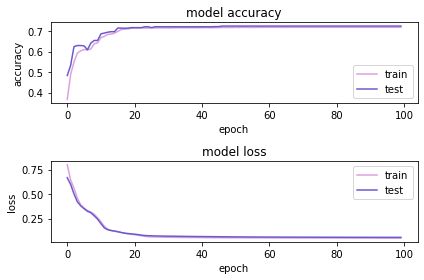

In [16]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], color='plum')
plt.plot(history.history['val_accuracy'], color='slateblue')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'], color='plum')
plt.plot(history.history['val_loss'], color='slateblue' )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()